In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astrotools.filters import Filters
from astrotools.models import BlackbodySED
from scipy.optimize import leastsq

%matplotlib inline
plt.rcParams['figure.figsize'] = 16, 8

In [45]:
sed = BlackbodySED(10000, 3e15, redshift=0.609, wavelength=np.arange(1000, 10000), template='/Users/szymon/Dropbox/SLSN/Templates/SLSN_12000.txt')
filters = Filters(load_all=True)

In [46]:
sed.synthesis_photometry(filter_name=['DES_g', 'DES_r', 'DES_i', 'DES_z'], filters=filters)

array([  4.35844472e-18,   4.31807281e-18,   3.19373582e-18,
         2.29690065e-18])

In [47]:
sed.update_blackbody(temperature=15000)

In [48]:
sed.synthesis_photometry(filter_name=['DES_g', 'DES_r', 'DES_i', 'DES_z'], filters=filters)

array([  2.19939240e-17,   1.55014161e-17,   9.49000591e-18,
         6.05685879e-18])

In [49]:
def R(t, R0, dR):
    return (R0 + dR * t) * 1e15

In [50]:
df_list = pd.read_csv('/Users/szymon/Dropbox/SLSN/For_Szymon/SLSN_fitted.list')
df_list['snname'] = df_list['name'].map(lambda x : x.rstrip('.txt').split('_')[-1])
SN = 7
df_list.head()

,name,min_mjd,max_mjd,p_0,p_1,snname
0,T_R_Evoluion_2011ke.txt,55651.58,55776.89,-394.465526,0.007176,2011ke
1,T_R_Evoluion_DES13S2cmm.txt,56532.74,56699.04,-834.118581,0.014807,DES13S2cmm
2,T_R_Evoluion_DES14C1fi.txt,56878.20,57050.00,-2122.528531,0.037348,DES14C1fi
3,T_R_Evoluion_DES14C1rhg.txt,56990.00,57045.00,-1925.044973,0.033794,DES14C1rhg
4,T_R_Evoluion_DES14E2slp.txt,57008.60,57052.56,-2852.199046,0.050052,DES14E2slp


In [51]:
df = pd.read_csv('/Users/szymon/Dropbox/SLSN/For_Szymon/GP_fits_all/' + df_list['snname'][SN] + '.lc')
filter_names = df.columns[range(1, df.shape[1], 2)].values
df_matrix = df.as_matrix().T

mjd = df_matrix[0]
flux = df_matrix[range(1, df.shape[1], 2)].T
err = df_matrix[1:][range(1, df.shape[1], 2)].T
df.head()

,mjd,DES_g,err_DES_g,DES_i,err_DES_i,DES_r,err_DES_r,DES_z,err_DES_z
0,57008.640000,3.355039e-18,7.839798e-19,7.905283e-19,1.958903e-19,1.517377e-18,2.899475e-19,5.334490e-19,3.898766e-19
1,57008.820457,3.364843e-18,7.429667e-19,7.962934e-19,1.884023e-19,1.523570e-18,2.747442e-19,5.348059e-19,3.841021e-19
2,57009.000914,3.374672e-18,7.025321e-19,8.020772e-19,1.810591e-19,1.529783e-18,2.597839e-19,5.361661e-19,3.783543e-19
3,57009.181371,3.384527e-18,6.627133e-19,8.078798e-19,1.738687e-19,1.536017e-18,2.450796e-19,5.375294e-19,3.726337e-19
4,57009.361828,3.394408e-18,6.235536e-19,8.137012e-19,1.668403e-19,1.542271e-18,2.306463e-19,5.388961e-19,3.669410e-19


In [52]:
def res(T, sed, flux, err, i):
    sed.update_blackbody(temperature=T)
    return (flux[i] - sed.synthesis_photometry(filter_name=filter_names, filters=filters)) # / err[i]

In [53]:
fit = []
T_arr = []
R_arr = []
for i in range(mjd.size):
    R_fit = R(mjd[i], df_list['p_0'][SN], df_list['p_1'][SN])
    R_arr.append(R_fit)
    
    sed.update_blackbody(radius=R_fit)
    T_fit, out = leastsq(res, x0=20000, args=(sed, flux, err, i), full_output=0)
    T_arr.append(T_fit)
    
    fit.append(np.concatenate([[mjd[i]], sed.synthesis_photometry(filter_name=filter_names, filters=filters)]))

fit = np.array(fit)
fit = pd.DataFrame(fit, columns=['mjd']+list(filter_names))
fit.head()

,mjd,DES_g,DES_i,DES_r,DES_z
0,57008.640000,3.061928e-18,1.089721e-18,1.904958e-18,6.665050e-19
1,57008.820457,3.065663e-18,1.099412e-18,1.916751e-18,6.735650e-19
2,57009.000914,3.069406e-18,1.109103e-18,1.928519e-18,6.806354e-19
3,57009.181371,3.073158e-18,1.118795e-18,1.940264e-18,6.877161e-19
4,57009.361828,3.076918e-18,1.128486e-18,1.951986e-18,6.948069e-19


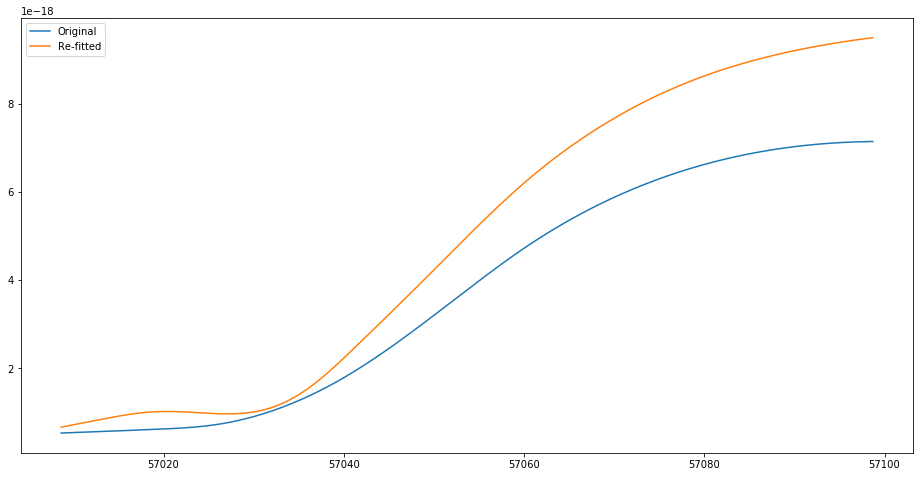

In [54]:
plt.plot(df['mjd'], df['DES_z'], label='Original')
plt.plot(fit['mjd'], fit['DES_z'], label='Re-fitted')
plt.legend(loc='best')

In [55]:
df_T_R = pd.read_csv('/Users/szymon/Dropbox/SLSN/For_Szymon/' + df_list['name'][SN], header=None)
df_T_R.columns = ['mjd', 'R', 'dR', 'T', 'dT']

In [56]:
df_T_R.head()

,mjd,R,dR,T,dT
0,57008.640000,8.595818e+14,2.280167e+08,20046.233215,5341.701776
1,57008.820457,8.644275e+14,2.224991e+08,19994.573113,5042.693506
2,57009.000914,8.693499e+14,2.169262e+08,19942.331102,4751.422450
3,57009.181371,8.743510e+14,2.112973e+08,19889.499299,4467.988417
4,57009.361828,8.794326e+14,2.056123e+08,19836.075381,4192.510362


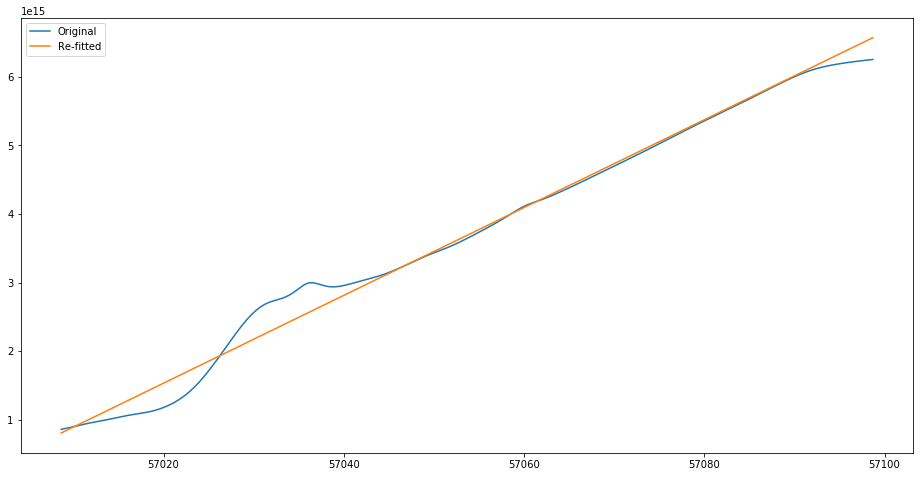

In [57]:
plt.plot(mjd, df_T_R['R'], label='Original')
plt.plot(mjd, R_arr, label='Re-fitted')
plt.legend(loc='best')

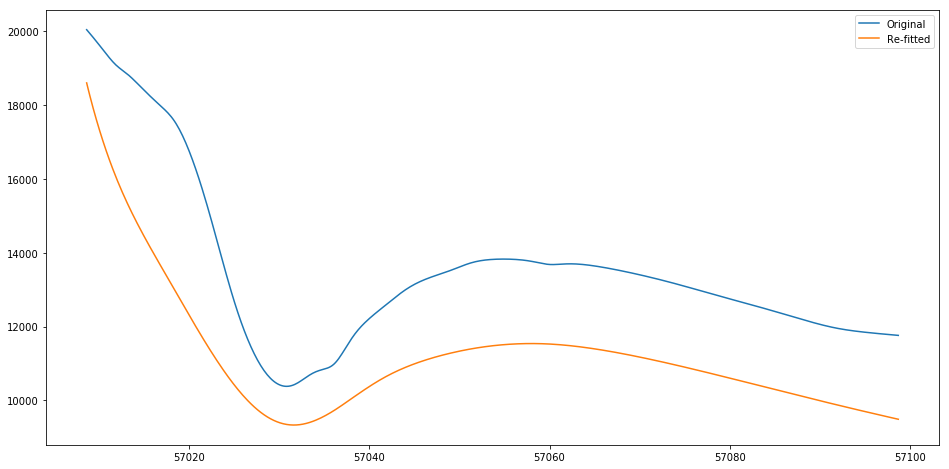

In [58]:
plt.cla()
plt.plot(mjd, df_T_R['T'], label='Original')
plt.plot(mjd, T_arr, label='Re-fitted')
plt.legend(loc='best')

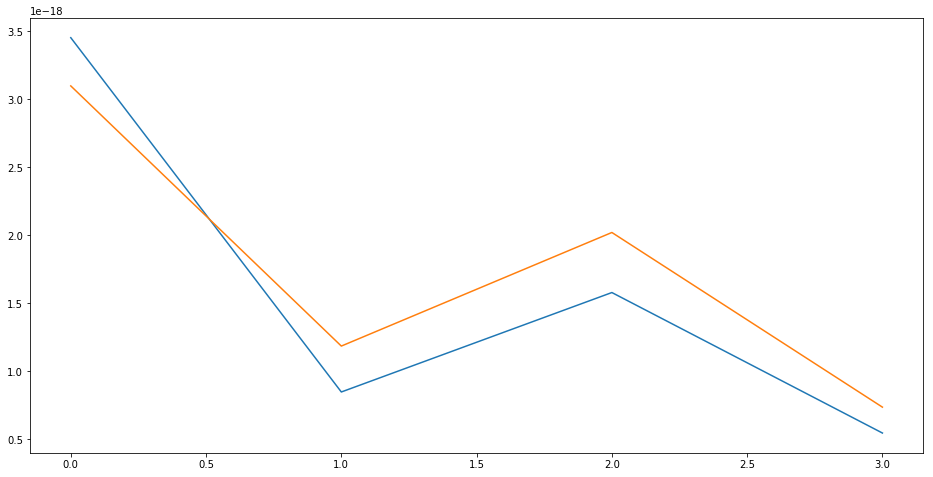

In [59]:
i = 10
plt.plot(flux[i])

sed.update_blackbody(radius=R_arr[i], temperature=T_arr[i])
plt.plot(sed.synthesis_photometry(filter_name=filter_names, filters=filters))